In [1]:
#COLAB
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -U bitsandbytes
!pip install fuzzywuzzy
!pip install python-Levenshtein
!pip install datasets

In [3]:
import pandas as pd
import numpy as np
import random
from collections import Counter
## The FuzzyWuzzy library is used to evaluate the similarity between text strings using Levenshtein similarity (a metric that measures the minimum number of changes
## needed to transform one string into another). This measure is useful for avoiding inconsistencies between the data passed to Mistral for generation and the generated data.
import fuzzywuzzy
from fuzzywuzzy import fuzz
import os
import re
import json
from huggingface_hub import login
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score
from transformers import BitsAndBytesConfig, AutoModelForCausalLM, AutoTokenizer, pipeline
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from datasets import load_dataset
import matplotlib.pyplot as plt

In [4]:
PROJ_FOLDER = './drive/My Drive/SN_project/' ## ---> Path to the folder that contains the project

# Import and clean data

Load the data and clean it, before the next steps

In [ ]:
DATA_FOLDER = os.path.join(PROJ_FOLDER,'data')
FILE_NAME = 'COP_26.csv'

df = pd.read_csv(os.path.join(DATA_FOLDER,FILE_NAME),encoding='unicode_escape')

if FILE_NAME  == 'COP_26.csv':
  df.rename(columns={'tweetContent': 'text'},inplace = True)

df.info()

In [ ]:
## Clean tweets ##
def remove_emoji(string):
    emoji_pattern = re.compile("["
                       u"\U0001F600-\U0001F64F"  # emoticons
                       u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                       u"\U0001F680-\U0001F6FF"  # transport & map symbols
                       u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                       u"\U00002702-\U000027B0"
                       u"\U000024C2-\U0001F251"
                       "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

def clean_tweet(tweet, remove_mentions=False, remove_hashtags=False, tokenize=False):
    temp = tweet
    temp = re.sub("'", "", temp)
    temp = remove_emoji(temp)
    temp = re.sub(r'http\S+', '', temp)
    temp = re.sub('\n', '', temp)
    temp = re.sub(r'[^\x00-\x7F]+', '', temp)
    temp = re.sub(r'[()!?]', ' ', temp)
    temp = re.sub(r'\[.*?\]', ' ', temp)

    if remove_mentions:
        temp = re.sub("@[A-Za-z0-9_]+", "", temp)
    if remove_hashtags:
        temp = re.sub("#\w+", "", temp)
    if tokenize:
        tokens = temp.split()
        temp = ' '.join(tokens)

    return temp

In [ ]:
df['Clean'] = df['text'].apply(clean_tweet)

In [ ]:
df[['text','Clean']].head()

In [ ]:
df['char_count'] = df['Clean'].apply(len)

In [ ]:
## Filter rows with <= 256 char ##
df.drop_duplicates(subset = ['Clean'],inplace = True)
df = df[df['char_count'] <= 256]

df.reset_index(drop=True, inplace=True)

In [ ]:
df.info()

In [ ]:
N = 5000
F = 0

if F == 0:
  tweets = df['Clean'].head(N)
else:
  tweets = df['Clean'].iloc[F*N+1:(F*N+1)+N]

tweets

# Load Mistral Instruct v.3

In [ ]:
key = "hugging_face_token"
login(key)

In [ ]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

In [ ]:
# Load Model and Tokenizer
MODEL_TYPE = "mistralai/Mistral-7B-Instruct-v0.3"
mistral_model = AutoModelForCausalLM.from_pretrained(MODEL_TYPE, device_map="auto",quantization_config=quantization_config,)
mistral_tokenizer = AutoTokenizer.from_pretrained(MODEL_TYPE)

# Utils

A bunch of methods and constants that we use later in the next steps

In [5]:
UTILS_PATH = os.path.join(PROJ_FOLDER,'utils') ## ---> Path to the folder that contains prompt.json and examples.json
PROMPT_PATH = os.path.join(UTILS_PATH,'prompt.json') ## ---> Contains the prompts that we will use later
EXAMPLES_PATH = os.path.join(UTILS_PATH,'examples.json') ## ---> Contains examples and chains
MISTRAL_RES_PATH = os.path.join(PROJ_FOLDER,'mistral_results') ## ---> Store the Mistral generated results
TRAIN_TEST_FOLDER = os.path.join(PROJ_FOLDER,'train_test_data') ## ---> Folder that contains train,test and validation set
TRAIN_RAW_FILE = os.path.join(TRAIN_TEST_FOLDER,'ABSA_dataset.jsonl') ## ---> File that contains the final dataset
TRAIN_FILE = os.path.join(TRAIN_TEST_FOLDER,'train.jsonl') ## ---> Train file
TEST_FILE = os.path.join(TRAIN_TEST_FOLDER,'test.jsonl') ## ---> Test file
VAL_FILE = os.path.join(TRAIN_TEST_FOLDER,'val.jsonl') ## --->  Validation file
MODEL_PATH = os.path.join(PROJ_FOLDER, "model/fine_tune_roberta_for_ABSA") ## ---> Path to the saved model and model results
RESULTS_MODEL_PATH = os.path.join(PROJ_FOLDER, "model/results") ## ---> Path to the model results

In [6]:
## Categories choose as labels to tag the spans (these will be the classes to use in the task of span categorization) ##
CATEGORIES = ["CONFERENCE","POLICIES_AND_STRATEGIES","GREEN_ENERGY","STAKEHOLDER","ORGANIZATION","SUSTAINABILITY","ENVIRONMENTAL_ISSUE"]
CATEGORIES_TRAIN = CATEGORIES

In [7]:
## Load prompt for different tasks ##
def load_prompt(file_path):
    with open(file_path, "r") as file:
        data = json.load(file)

    types =['zs','fs','cot']

    prompt_fs = ''
    prompt_zs = ''
    prompt_cot = ''

    choise = 0

    for t in types:

      l = data["prompt"][t]

      if t == 'fs' and (len(l) != 0):
          prompt_fs = prompt_fs + l[choise]

      elif t == 'zs' and (len(l) != 0):
          prompt_zs = prompt_zs + l[choise]

      else:
          prompt_cot = prompt_cot + l[choise]

    return prompt_fs,prompt_zs,prompt_cot


## Load examples for few shot and cot tasks ##
def load_ex(file_path):
  with open(file_path, "r") as file:
    data = json.load(file)

  types =['fs','cot']

  examples_fs = []
  examples_cot = []

  for t in types:

    for e in data["examples"][t]:
      if t == 'fs':
          examples_fs.append(e)

      else :
          examples_cot.append(e)


  return examples_fs,examples_cot

In [8]:
## Utility function to aggregate the examples defined in the file examples.json ##
def take_examples(l,n):
  ex = ""
  for i in range (n):
    ex = ex + l[i] + '\n'
  return ex

## Utility function to aggregate the chain defined in the file examples.json ##
def take_chain(l,n):
  ch = ""
  for i in range(n):
    if i == n-1:
      ch += l[i] +'\n'
    else:
      ch += l[i] + '\n' + 'Another example, let s think step by step\n'

  return ch

In [9]:
## Extract only the payload of the results given by Mistral generation ##
def extract_output_from_response(text):
  pattern1 = r'\{\s*"span":\s*"[^"]*"\s*,\s*"polarity":\s*"[^"]*"\s*,\s*"category":\s*"[^"]*"\s*\}'
  matches = re.findall(pattern1, text)

  return "".join(matches)

## Save the results of processed tweets trough Mistral ##
def save_results(file_path,results,verbose = True):

  with open(file_path, "a") as f:
      for e in results:
        try:

          s = e[1]
          t = e[0]
          #s = extract_output_from_response(s)
          s = s.replace("\n","").replace("}{","},{")
          s = '['+ s + ']'
          json_lab = json.loads(s)

          for i in json_lab:
            if i['category'] not in CATEGORIES:
              json_lab.remove(i)

          d = {"text" : t,
                "labels" : json_lab}


          #d_json = json.dumps(d,indent = 4)
          d_json = json.dumps(d)

          f.write(d_json+'\n')

        except Exception as e:

          if verbose:
              print("Errore nel salvataggio dell' oggetto")
              print(s)

          s1 = extract_output_from_response(s)
          s1 = s1.replace("\n","").replace("}{","},{")
          s1 = '['+ s1 + ']'
          json_lab1 = json.loads(s1)

          for i in json_lab1:
            if i['category'] not in CATEGORIES:
              json_lab1.remove(i)

          d1 = {"text" : t,
                "labels" : json_lab1}

          #d_json1 = json.dumps(d1, indent = 4)
          d_json1 = json.dumps(d1)
          f.write(d_json1+'\n')

In [10]:
## Methods used to add information as start,end position, to the generated example by Mistral ##

def find_similar_tokens(text, token, threshold=80):
    """
    Find tokens in the sentence that are similar to the given token.

    Args:
        text (str): The sentence to search in.
        token (str): The token to compare.
        threshold (int): The similarity threshold (0-100).

    Returns:
        List[dict]: A list of dictionaries with `token`, `start`, `end`, and `similarity`.
    """

    words = text.split()
    results = ()

    start_pos = 0
    for word in words:
        similarity = fuzz.ratio(word, token)
        if similarity >= threshold:
            # Trova posizione di inizio e fine
            start = text.find(word, start_pos)
            end = start + len(word)
            results = (start,end)
            #results.append({"token": word, "start": start, "end": end, "similarity": similarity})
        start_pos += len(word) + 1

    return results


def get_token_indices(text, token):
    """
    Find the start and end positions of all occurrences of a token in a string.

    Args:
        text (str): The string to search in.
        token (str): The token to search for.

    Returns:
        List[tuple]: A list of tuples (start, end) with the start and end positions.
    """

    indices = []
    start = 0

    while start < len(text):
        start = text.find(token, start)
        if start == -1:
            break
        end = start + len(token)
        indices.append((start, end))
        start = end

    if len(indices) == 0:
        t_n = find_similar_tokens(text, token, threshold=80)
        indices.append(t_n)

    return indices

## Add offset info to the generated response ##
def add_start_end_offset(data):
    text = data["text"]
    for label in data["labels"]:
            if label != None:
                span = label["span"]
                span_indices = get_token_indices(text, span)
                if span_indices[0] != ():
                  label["start"] = span_indices[0][0]
                  label["end"] = span_indices[0][1]
                else:
                  label["start"] = -1
                  label["end"] = -1

    return data

## Save the final dataset after add offset info ##
def save_offset_data(src,dst = TRAIN_TEST_FOLDER):
  data_offset = []

  with open(src, 'r') as f:
      for line in f:
          data = json.loads(line)
          add_start_end_offset(data)
          data_offset.append(data)

  p_file = os.path.join(TRAIN_TEST_FOLDER,'ABSA_dataset.jsonl')

  os.makedirs(os.path.dirname(p_file), exist_ok=True)

  with open(p_file, 'w') as f:
    for data in data_offset:
      filtered_data = {
          "text": data["text"],
          "labels": [label for label in data["labels"] if (label != None) or (label["start"] != -1)]
      }
      f.write(json.dumps(filtered_data) + '\n')

In [11]:
def clean_split_results(src_f, train_f, test_f, val_f, categories = CATEGORIES_TRAIN, train_ratio=0.8, val_ratio=0.1):
    """
    Cleans the JSON lines in the source file, splitting them into train, test, and validation files.
    Lines with an empty `labels` list are not saved.

    Args:
        src_f (str): Path to the source file.
        train_f (str): Path to the output file for the train set.
        test_f (str): Path to the output file for the test set.
        val_f (str): Path to the output file for the validation set.
        categories (list): List of allowed categories.
        train_ratio (float): Percentage of lines to include in the train set (default 80%).
        val_ratio (float): Percentage of lines to include in the validation set (default 10%).

    Returns:
        tuple: Three lists containing the data for the train set, validation set, and test set, respectively.
    """

    train_data = []
    test_data = []
    val_data = []

    with open(src_f, 'r') as f, open(train_f, 'w') as f_train, open(test_f, 'w') as f_test, open(val_f, 'w') as f_val:
        for line in f:
            data = json.loads(line.strip())


            if "labels" in data and isinstance(data["labels"], list):

                data["labels"] = [item for item in data["labels"] if item.get("category") in categories]


            if data.get("labels"):
                rand = random.random()
                if rand < train_ratio:
                    train_data.append(data)
                    f_train.write(json.dumps(data) + '\n')
                elif rand < train_ratio + val_ratio:
                    val_data.append(data)
                    f_val.write(json.dumps(data) + '\n')
                else:
                    test_data.append(data)
                    f_test.write(json.dumps(data) + '\n')

    return train_data, val_data, test_data


In [12]:
## For each category print the number of occurences in the dataset ##

def category_counter(cat,file_path):
  category_counter = Counter()

  with open(file_path, "r", encoding="utf-8") as f:
      for line in f:
          data = json.loads(line.strip())

          if "labels" in data and isinstance(data["labels"], list):
              for label in data["labels"]:
                  if isinstance(label, dict):
                      if cat == 'cat':
                        category = label.get("category", None)
                      else:
                        category = label.get("polarity", None)
                      if isinstance(category, str):
                          category_counter[category] += 1

  sorted_categories = category_counter.most_common()
  return sorted_categories

In [13]:
## Tag the token with I B method ##

def get_token_role_in_span(token_start, token_end, span_start, span_end):
    """
    Check if the token is inside a span.
    Args:
      - token_start, token_end: Start and end offset of the token
      - span_start, span_end: Start and end of the span
    Returns:
      - "B" if beginning
      - "I" if inner
      - "O" if outer
      - "N" if not valid token (like <SEP>, <CLS>, <UNK>)
    """
    if token_end <= token_start:
        return "N"
    if token_start < span_start or token_end > span_end:
        return "O"
    if token_start > span_start:
        return "I"
    else:
        return "B"

In [14]:
## Print the token-labels info for each token ##

def control_output(sample,label,d,tokenizer):
  print("--------Token---------|--------Labels----------")
  for token_id, token_labels in zip(sample["input_ids"], sample[label]):
      # Decode the token_id into text
      token_text = tokenizer.decode(token_id)
      if token_text == '</s>':
        break

      # Retrieve all the indices corresponding to the "1" at each token, decode them to label name
      labels = [d[label_index] for label_index, value in enumerate(token_labels) if value==1]

      # Decode those indices into label name
      print(f" {token_text:20} | {labels}")
      # Finish when we meet the end of sentence.

In [15]:
def control_count_output_aggregated(samples, label, d, tokenizer):
    """
    Prints the tokens and associated labels for each example, and computes the aggregated sum of label occurrences.

    Args:
        - samples (list[dict]): List of dictionaries, each representing an example.
        - label (str): Name of the key in the dictionaries that contains the labels.
        - d (dict): Dictionary mapping indices to labels.
        - tokenizer: Tokenizer used to decode the token IDs.

    Returns:
        - aggregated_counts (dict): Dictionary with the sum of occurrences for each label.
    """

    aggregated_counts = {label_name: 0 for label_name in d.values()}  # Inizializza il conteggio aggregato
    total_occurrences = 0

    for sample_idx, sample in enumerate(samples):
        # Contatori per l'esempio corrente
        example_counts = {label_name: 0 for label_name in d.values()}

        #print(f"\nEsempio {sample_idx + 1}")
        #print("--------Token---------|--------Labels----------")
        for token_id, token_labels in zip(sample["input_ids"], sample[label]):
            # Decodifica il token_id in testo
            token_text = tokenizer.decode([token_id]).strip()
            if token_text == '</s>':
                break

            # Recupera gli indici con valore "1" e decodifica in nomi di etichette
            labels = [d[label_index] for label_index, value in enumerate(token_labels) if value == 1]

            # Incrementa il conteggio delle etichette per l'esempio corrente
            for label_name in labels:
                example_counts[label_name] += 1

            # Stampa il token e le sue etichette
            #print(f" {token_text:20} | {labels}")

        # Stampa il conteggio per l'esempio corrente
        # print("\n--------Label Occurrences for Example----------")
        # for label_name, count in example_counts.items():
        #     print(f"{label_name:20} : {count}")

        # Aggiungi i conteggi dell'esempio corrente a quelli aggregati
        for label_name, count in example_counts.items():
            aggregated_counts[label_name] += count
            total_occurrences += count

    # Stampa i conteggi aggregati per tutti gli esempi
    # print("\n--------Aggregated Label Occurrences----------")
    # for label_name, count in aggregated_counts.items():
    #     print(f"{label_name:20} : {count}")

    return aggregated_counts, total_occurrences


In [16]:
## Methods used to calculate weights to use later with the Focal Loss, due to the class imbalance ##
def count_categories(d):
  n = 0
  for e, c in d:
    n += c
  return n

def compute_weights(n,d):
  dw = {}
  for e,c in d.items():
    w = np.log(1 + (n/c))
    dw[e] = w

  return dw

def assign_weights(id2tag,d):
    w = []
    for k,v in id2tag.items():
        w.append(d[v])
    return w

In [17]:
## Function to manage overlapping spans and prioritize sentiment ##

def handle_overlapping_spans(token_start, token_end, sample_labels):
        """ Returns the final sentiment label for overlapping spans """
        sentiments = set()
        for span in sample_labels:
            if span is None or span.get('polarity') is None:
                continue

            if span['start'] <= token_end and span['end'] >= token_start:
                sentiments.add(span['polarity'])

        if "negative" in sentiments:
            return "negative"
        elif "positive" in sentiments:
            return "positive"
        elif "neutral" in sentiments:
            return "neutral"
        return None

In [18]:
## Used to find the examples with overlapping spans ##

def find_overlapping_spans(ds):
    idx = []
    c = 0
    for sample in ds:
        matrix = np.array(sample['labels_cat'])
        r = np.where(matrix.sum(axis=1) >= 2)[0]
        if r.size > 0:
            idx.append(c)
        c +=1
    return idx

In [169]:
## Save the metrics in a new format ##

def partition_results(results):
    partitioned_results = {
        "task1": {},
        "task2": {},
        "overall": {},
        "performance": {},
        "categories_metrics": {},
        "categories_metrics_aggregated": {},
        "sentiment_metrics" : {}
    }

    for key, value in results.items():
        if key.startswith("test_overall") :
            partitioned_results["overall"][key] = value
        elif "task1" in key:
            partitioned_results["task1"][key] = value
        elif "task2" in key:
            partitioned_results["task2"][key] = value
        elif "comb" in key and "f1" in key:
            partitioned_results["categories_metrics_aggregated"][key] = value
        elif "test_f1_B" in key or "test_f1_I" in key:
            partitioned_results["categories_metrics"][key] = value
        elif "negative" in key or "positive" in key or "neutral" in key:
            partitioned_results["sentiment_metrics"][key] = value
        elif key in ["test_loss", "test_runtime", "test_samples_per_second", "test_steps_per_second"]:
            partitioned_results["performance"][key] = value

    return partitioned_results

In [20]:
## Save model metrics ##
def save_metrics_to_file(results, file_path):
    """
    Salva i risultati su un file JSON.
    """
    with open(file_path, "w") as f:
        json.dump(results, f, indent = 4)
    print(f"Risultati salvati in {file_path}")

## Load model metrics from file ##
def load_metrics_from_file(file_path):
    """
    Carica i risultati da un file JSON.
    """
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Il file {file_path} non esiste!")
    with open(file_path, "r") as f:
        results = json.load(f)
    return results

In [21]:
## Plot Macro metrics ##

def plot_metrics(data, output_file=None):
    macro_scores = {
        "Task1 Macro F1": data["task1"]["test_macro_f1_task1"],
        "Task2 Macro F1": data["task2"]["test_macro_f1_task2"],
        "Overall Macro F1": data["overall"]["test_overall_macro_f1"],
        "Task1 Macro Precision": data["task1"]["test_macro_precision_task1"],
        "Task2 Macro Precision": data["task2"]["test_macro_precision_task2"],
        "Overall Macro Precision": data["overall"]["test_overall_macro_precision"],
        "Task1 Macro Recall": data["task1"]["test_macro_recall_task1"],
        "Task2 Macro Recall": data["task2"]["test_macro_recall_task2"],
        "Overall Macro Recall": data["overall"]["test_overall_macro_recall"]
    }

    fig, axes = plt.subplots(1, 3, figsize=(15, 6))
    metrics = ["F1", "Precision", "Recall"]

    for i, metric in enumerate(metrics):
        axes[i].bar(["Task1", "Task2", "Overall"],
                       [macro_scores[f"Task1 Macro {metric}"],
                        macro_scores[f"Task2 Macro {metric}"],
                        macro_scores[f"Overall Macro {metric}"]],
                       color=['skyblue', 'orange', 'green'], width=0.5, edgecolor="black")
        axes[i].set_title(f"Macro {metric} Scores")
        axes[i].set_ylim(0, 1)

    plt.tight_layout()
    if output_file:
        plt.savefig(output_file)
    plt.show()

In [183]:
## Plot F1 for each categories in task1 ##

def plot_f1_categories(data, aggregated = True, output_file = None):
  if aggregated:
    categories_metrics = data["categories_metrics_aggregated"]
  else:
    categories_metrics = data["categories_metrics"]

  categories = list(categories_metrics.keys())
  values = list(categories_metrics.values())

  base_colors = ['skyblue', 'lightgreen', 'coral', 'plum', 'gold', 'lightpink', 'gray']

  if aggregated:
    colors = base_colors
  else:
    colors = []
    for i, category in enumerate(categories):
        color = base_colors[i // 2 % len(base_colors)]
        colors.append(color)

  plt.figure(figsize=(14, 6))
  plt.bar(categories, values, color=colors, edgecolor="black")
  plt.xticks(rotation=45, ha="right", fontsize=10)
  plt.ylabel("F1 Score", fontsize=12)
  plt.xlabel("Metrics", fontsize=12)
  plt.title("F1 Scores by Category", fontsize=14)
  plt.tight_layout()

  if output_file:
      plt.savefig(output_file)

  plt.show()

In [23]:
## Plot the distribution of class ##
def plot_stratified_split(d,color,name):
  d_cat_count = {k: v for k, v in d}

  categories = d_cat_count.keys()
  occurrences = d_cat_count.values()

  plt.figure(figsize=(14, 5))
  plt.barh(categories, occurrences, color=color, edgecolor="black")
  plt.xlabel("Occurrences", fontsize=12)
  plt.ylabel("Categories", fontsize=12)
  plt.title(f"Distribution of Categories {name}", fontsize=14)
  plt.gca().invert_yaxis()
  plt.tight_layout()

  plt.show()


In [24]:
def get_offsets_and_predicted_tags(example: str, model, tokenizer, threshold= 0.5):
    """
    Get prediction of model on example, using tokenizer
    Args:
      - example (str): The input text
      - model: The span categorizer
      - tokenizer: The tokenizer
      - threshold: The threshold to decide whether the token should belong to the label. Default to 0, which corresponds to probability 0.5.
    Returns:
      - List of dictionaries with token, tags, polarity, and offset for each token.
    """
    raw_encoded_example = tokenizer(
        example, return_offsets_mapping=True, truncation=True, padding=False
    )
    encoded_example = tokenizer(
        example, return_tensors="pt", truncation=True, padding=False
    )

    with torch.no_grad():
        outputs = model(**encoded_example)

    logits_cat, logits_pol = outputs["logits"]

    logits_cat = torch.sigmoid(torch.squeeze(logits_cat,0))
    logits_pol = torch.sigmoid(torch.squeeze(logits_pol,0))

    predicted_tags_cat = (logits_cat > threshold).nonzero(as_tuple=False).tolist()
    predicted_tags_pol = (logits_pol > threshold).nonzero(as_tuple=False).tolist()

    tokens = tokenizer.batch_decode(encoded_example["input_ids"][0], skip_special_tokens=True)
    offsets = raw_encoded_example["offset_mapping"]

    result = []

    for token, offset in zip(tokens, offsets):
        cat_tags = [tag for tag in predicted_tags_cat if tag[0] == tokens.index(token)]
        pol_tags = [tag for tag in predicted_tags_pol if tag[0] == tokens.index(token)]

        result.append({
            "token": token,
            "categories": [tag[1] for tag in cat_tags],
            "polarities": [tag[1] for tag in pol_tags],
            "offset": offset,
        })

    return result

# Prompt and examples

Define the prompts and examples for:
- Few Shots Prompt;
- Zero Shot Prompt;
- Chain of Thought;

In [ ]:
ex1 = '**Text**: At the United Nations Climate Change Conference, policy makers unveiled new strategies aimed at reducing carbon emissions and promoting green energy solutions for future generations.\n\
**Output**: {"span": "United Nations Climate Change Conference", "polarity": "neutral", "category": "CONFERENCE"},\
{"span": "policy makers", "polarity": "neutral", "category": "STAKEHOLDER"},\
{"span": "policy makers unveiled new strategies aimed at reducing carbon emissions and promoting green energy solutions", "polarity": "positive", "category": "POLICIES_AND_STRATEGIES"},\
{"span": "carbon emissions", "polarity": "positive", "category": "ENVIRONMENTAL_ISSUE"},\
{"span": "green energy solutions", "polarity": "positive", "category": "GREEN_ENERGY"}'

In [ ]:
ex2 = '**Text**: The government of Norway has proposed a policy to increase investments in carbon capture technologies to combat climate change and ensure long-term sustainability.\n\
**Output**: {"span": "government of Norway", "polarity": "neutral", "category": "STAKEHOLDER"},\
{"span": "proposed a policy to increase investments in carbon capture technologies", "polarity": "positive", "category": "POLICIES_AND_STRATEGIES"},\
{"span": "carbon capture technologies", "polarity": "positive", "category": "GREEN_ENERGY"},\
{"span": "climate change", "polarity": "negative", "category": "ENVIRONMENTAL_ISSUE"},\
{"span": "long-term sustainability", "polarity": "positive", "category": "SUSTAINABILITY"}'

In [ ]:
ex3 = '**Text**: During the Paris Climate Agreement, world leaders discussed the urgent need to implement more ambitious policies to transition to renewable energy and safeguard the environment.\n\
**Output**: {"span": "Paris Climate Agreement", "polarity": "neutral", "category": "CONFERENCE"},\
{"span": "world leaders", "polarity": "neutral", "category": "STAKEHOLDER"},\
{"span": "world leaders discussed the urgent need to implement more ambitious policies to transition to renewable energy", "polarity": "positive", "category": "POLICIES_AND_STRATEGIES"},\
{"span": "transition to renewable energy", "polarity": "positive", "category": "GREEN_ENERGY"},\
{"span": "safeguard the environment", "polarity": "positive", "category": "SUSTAINABILITY"}'

In [ ]:
ex4 = '**Text**: The new report from the IPCC outlines strategies for reducing global warming by investing in clean technologies, reducing emissions, and promoting sustainable practices.\n\
**Output**: {"span": "IPCC", "polarity": "neutral", "category": "ORGANIZATION"},\
{"span": "strategies for reducing global warming", "polarity": "positive", "category": "POLICIES_AND_STRATEGIES"},\
{"span": "global warming", "polarity": "negative", "category": "ENVIRONMENTAL_ISSUE"},\
{"span": "clean technologies", "polarity": "positive", "category": "GREEN_ENERGY"},\
{"span": "reducing emissions", "polarity": "positive", "category": "ENVIRONMENTAL_ISSUE"},\
{"span": "promoting sustainable practices", "polarity": "positive", "category": "SUSTAINABILITY"}'

In [ ]:
ex5 = '**Text**: The transition to renewable energy in countries like Germany and Denmark is being supported by advanced solar technologies and government-backed green energy policies.\n\
**Output**: {"span": "transition to renewable energy", "polarity": "positive", "category": "SUSTAINABILITY"},\
{"span": "renewable energy", "polarity": "neutral", "category": "GREEN_ENERGY"},\
{"span": "advanced solar technologies", "polarity": "positive", "category": "GREEN_ENERGY"},\
{"span": "government-backed", "polarity": "positive", "category": "STAKEHOLDER"},\
{"span": "government-backed green energy policies", "polarity": "positive", "category": "POLICIES_AND_STRATEGIES"}'

In [ ]:
ex6 = '**Text**: Tesla, led by Elon Musk, is playing a pivotal role in promoting the global adoption of electric vehicles, while organizations like Greenpeace advocate for stronger environmental policies worldwide.\n\
**Output**: {"span": "Tesla", "polarity": "positive", "category": "ORGANIZATION"},\
{"span": "Elon Musk", "polarity": "positive", "category": "STAKEHOLDER"},\
{"span": "promoting the global adoption of electric vehicles", "polarity": "positive", "category": "SUSTAINABILITY"},\
{"span": electric vehicles", "polarity": "positive", "category": "GREEN_ENERGY"},\
{"span": "Greenpeace", "polarity": "positive", "category": "ORGANIZATION"},\
{"span": "stronger environmental policies", "polarity": "positive", "category": "POLICIES_AND_STRATEGIES"}'

In [ ]:
ex7 = '**Text**: The Bill and Melinda Gates Foundation, spearheaded by Bill Gates, has significantly contributed to combating global health crises, while the UN supports these efforts through international partnerships.\n\
**Output**: {"span": "Bill and Melinda Gates Foundation", "polarity": "positive", "category": "ORGANIZATION"},\
{"span": "Bill Gates", "polarity": "positive", "category": "STAKEHOLDER"},\
{"span": "combating global health crises", "polarity": "positive", "category": "SUSTAINABILITY"},\
{"span": "global health crises", "polarity": "negative", "category": "ENVIRONMENTAL_ISSUE"},\
{"span": "UN", "polarity": "positive", "category": "ORGANIZATION"},\
{"span": "UN supports these efforts through international partnerships", "polarity": "positive", "category": "POLICIES_AND_STRATEGIES"}'

In [ ]:
ex8 = '**Text**: During COP28,located in Dubai, António Guterres urged world leaders and organizations like Greenpeace to accelerate climate action, emphasizing the importance of renewable energy and phasing out fossil fuels.\n\
**Output**: {"span": "COP28", "polarity": "neutral", "category": "CONFERENCE"},\
{"span": "António Guterres", "polarity": "positive", "category": "STAKEHOLDER"},\
{"span": "world leaders", "polarity": "neutral", "category": "STAKEHOLDER"},\
{"span": "Greenpeace", "polarity": "positive", "category": "ORGANIZATION"},\
{"span": "climate action", "polarity": "positive", "category": "SUSTAINABILITY"},\
{"span": "renewable energy", "polarity": "positive", "category": "GREEN_ENERGY"},\
{"span": "phasing out fossil fuels", "polarity": "positive", "category": "ENVIRONMENTAL_ISSUES"},\
{"span": "António Guterres urged world leaders and organizations like Greenpeace", "polarity": "positive", "category": "POLICIES_AND_STRATEGIES"}'

In [ ]:
ex9 = '**Text**: At COP28, critics accused certain governments, such as Brazil and Australia, of failing to meet their climate pledges, citing continued deforestation and coal mining activities.\n\
**Output**: {"span": "COP28", "polarity": "neutral", "category": "CONFERENCE"},\
{"span": "certain governments", "polarity": "negative", "category": "STAKEHOLDER"},\
{"span": "failing to meet their climate pledges", "polarity": "negative", "category": "POLICIES_AND_STRATEGIES"},\
{"span": "continued deforestation and coal mining activities", "polarity": "negative", "category": "ENVIRONMENTAL_ISSUE"}'

In [ ]:
ex10 = '**Text**: Despite the promises made at COP28, corporations like Chevron and Shell faced backlash for lobbying against stricter climate regulations, which activists argue undermines global efforts to combat climate change.\n\
**Output**: {"span": "COP28", "polarity": "neutral", "category": "CONFERENCE"},\
{"span": "corporations like Chevron and Shell", "polarity": "negative", "category": "ORGANIZATION"},\
{"span": "Chevron", "polarity": "negative", "category": "ORGANIZATION"},\
{"span": "Shell", "polarity": "negative", "category": "ORGANIZATION"},\
{"span": "lobbying against stricter climate regulations", "polarity": "negative", "category": "POLICIES_AND_STRATEGIES"},\
{"span": "activists", "polarity": "neutral", "category": "STAKEHOLDER"},\
{"span": "undermines global efforts to combat climate change", "polarity": "negative", "category": "ENVIRONMENTAL_ISSUE"},\
{"span": "climate change", "polarity": "negative", "category": "ENVIRONMENTAL_ISSUE"}'


In [ ]:
chain = '**Example Walkthrough**:\n\
\n\
**Text**:\n\
"At the #COP28 summit in #Dubai, global leaders from around the world, and various organizations, like Greenpeace, came together to discuss innovative #GreenEnergy solutions. They emphasized the importance of #Technology, like AI-driven carbon capture systems, in combating #ClimateChange. Several key #Stakeholders, including @ElonMusk and @BillGates, presented strategies for mitigating the impact of deforestation and promoting #Sustainability. The role of governments in regulating industries was also debated, with action plans for #EnergyTransition already in place. The focus is clear: reduce emissions and protect the environment for future generations."\n\
\n\
**STEP 1**: Identify the main spans in the text, including overlapping spans:\n\
The spans found are:\n\
"#COP28","Greenpeace","global leaders", "@ElonMusk", "@BillGates", "innovative #GreenEnergy solutions", "#GreenEnergy", "AI-driven carbon capture systems", "#ClimateChange","presented strategies for mitigating the impact of deforestation", "deforestation", "#Sustainability", "governments", "regulating industries", "#EnergyTransition", "reduce emissions", "protect the environment".\n\
\n\
Note:\n\
There are overlapping spans, that belongs to different categories:\n\
- "innovative #GreenEnergy solutions" overlaps with "#GreenEnergy" (the first belongs to category "POLICIES_AND_STRATEGIES", and the latter belongs to "GREEN_ENERGY").\n\
- "deforestation" overlaps with "presented strategies for mitigating the impact of deforestation" (deforestation belongs to category "ENVIRONMENTAL_ISSUE", and  the latter belongs to "POLICIES_AND_STRATEGIES").\n\
\n\
**STEP 2**: Classify the polarity of each span:\n\
- "#COP28" - neutral (conference reference);\n\
- "GreenPeace" - neutral (organization);\n\
- "global leaders" - neutral (description of stakeholders);\n\
- "@ElonMusk" - neutral (individual stakeholder);\n\
- "@BillGates" - neutral (individual stakeholder);\n\
- "innovative #GreenEnergy solutions" - positive (solution-oriented);\n\
- "#GreenEnergy" - positive (environmentally sustainable energy);\n\
- "AI-driven carbon capture systems" - positive (emerging technology for emissions reduction);\n\
- "#ClimateChange" - negative (environmental issue);\n\
- "deforestation" - negative (environmental issue);\n\
- "presented strategies for mitigating the impact of deforestation" - positive (solution-oriented);\n\
- "#Sustainability" - positive (goal of sustainable practices);\n\
- "governments" - neutral (political stakeholders);\n\
- "regulating industries" - neutral (action by governments);\n\
- "#EnergyTransition" - positive (shift to sustainable energy sources);\n\
- "reduce emissions" - positive (goal-oriented mitigation strategy);\n\
- "protect the environment" - positive (goal of environmental protection);\n\
\n\
**STEP 3**: Assign the category for each span:\n\
- "#COP28" is **CONFERENCE**, as it refers to a significant international conference;\n\
- "Greenpeace" is **ORGANIZATION**, as it refers to a non-profit organization;\n\
- "global leaders" is **STAKEHOLDER**, as it refers to political figures or representatives;\n\
- "@ElonMusk" is **STAKEHOLDER**, as it refers to an individual influential in climate discussions;\n\
- "@BillGates" is **STAKEHOLDER**, as it refers to another key individual in the climate change discourse;\n\
- "innovative #GreenEnergy solutions" is **POLICIES_AND_STRATEGIES**, as it refers to renewable energy initiatives;\n\
- "#GreenEnergy" is **GREEN_ENERGY**, as it refers to sustainable energy alternatives;\n\
- "AI-driven carbon capture systems" is **GREEN_ENERGY**, as it refers to advanced methods for emissions capture;\n\
- "#ClimateChange" is **ENVIRONMENTAL_ISSUE**, as it is the overarching environmental issue;\n\
- "deforestation" is **ENVIRONMENTAL_ISSUE**, as it is a key environmental issue contributing to climate change;\n\
- "presented strategies for mitigating the impact of deforestation" is **POLICIES_AND_STRATEGIES**, as it refers to strategies for mitigating climate change;\n\
- "#Sustainability" is **SUSTAINABILITY**, as it refers to practices aimed at maintaining ecological balance;\n\
- "governments" is **STAKEHOLDER**, as it refers to political entities responsible for policy decisions;\n\
- "regulating industries" is **POLICIES_AND_STRATEGIES**, as it refers to actions taken by governments to control industries;\n\
- "#EnergyTransition" is **GREEN_ENERGY**, as it refers to the shift from fossil fuels to renewable energy sources;\n\
- "reduce emissions" is **POLICIES_AND_STRATEGIES**, as it refers to efforts to lower harmful environmental impacts;\n\
- "protect the environment" is **SUSTAINABILITY**, as it refers to efforts aimed at safeguarding ecosystems;\n\
\n\
**Output**:\n\
{"span": "#COP28", "polarity": "neutral", "category": "CONFERENCE"},\n\
{"span": "Greenpeace", "polarity": "neutral", "category": "ORGANIZATION"},\n\
{"span": "global leaders", "polarity": "neutral", "category": "STAKEHOLDER"},\n\
{"span": "@ElonMusk", "polarity": "neutral", "category": "STAKEHOLDER"},\n\
{"span": "@BillGates", "polarity": "neutral", "category": "STAKEHOLDER"},\n\
{"span": "innovative #GreenEnergy solutions", "polarity": "positive", "category": "POLICIES_AND_STRATEGIES"},\n\
{"span": "#GreenEnergy", "polarity": "positive", "category": "GREEN_ENERGY"},\n\
{"span": "AI-driven carbon capture systems", "polarity": "positive", "category": "GREEN_ENERGY"},\n\
{"span": "#ClimateChange", "polarity": "negative", "category": "ENVIRONMENTAL_ISSUE"},\n\
{"span": "deforestation", "polarity": "negative", "category": "ENVIRONMENTAL_ISSUE"},\n\
{"span": "presented strategies for mitigating the impact of deforestation", "polarity": "positive", "category": "POLICIES_AND_STRATEGIES"},\n\
{"span": "#Sustainability", "polarity": "positive", "category": "SUSTAINABILITY"},\n\
{"span": "governments", "polarity": "neutral", "category": "STAKEHOLDER"},\n\
{"span": "regulating industries", "polarity": "neutral", "category": "POLICIES_AND_STRATEGIES"},\n\
{"span": "#EnergyTransition", "polarity": "positive", "category": "GREEN_ENERGY"},\n\
{"span": "reduce emissions", "polarity": "positive", "category": "POLICIES_AND_STRATEGIES"},\n\
{"span": "protect the environment", "polarity": "positive", "category": "SUSTAINABILITY"}\n'

In [ ]:
DEFAULT_PROMPT = 'I give you the following **TOPICS**:\n\
- **Topics**: [\"Climate Change\", \"Pollution\", \"Renewable Energy\","COP"]\n\
\n\
Using these TOPICS, analyze the input text and complete the following tasks:\n\
\n\
### TASK 1:\n\
Identify all spans in the text that are DIRECTLY RELATED to the TOPICS and belongs to these CATEGORIES:\n\
["CONFERENCE","POLICIES_AND_STRATEGIES","GREEN_ENERGY","STAKEHOLDER","ORGANIZATION","SUSTAINABILITY","ENVIRONMENTAL_ISSUE"].\n\
Do not include in the output any spans not related to CATEGORIES.\n\
- Spans can overlap; therefore, include nested spans if they are related to the CATEGORIES.\n\
\n\
### TASK 2:\n\
Determine the **sentiment** of each identified span. Sentiment options are:\n\
- \"positive,\" \"neutral,\" or \"negative.\"\n\
\n\
### TASK 3:\n\
Determine the **category** of each span and return only the uppercase name of the category.\n\
\n\
### OUTPUT CASES:\n\
- **CASE 1**: If you identify one or more spans, return each result in the following format, without adding extra information:\n\
- **DESIRED OUTPUT FORMAT**:\n\
  { \"span\": \"<identified span>\", \"polarity\": \"<sentiment>\", \"category\": \"<CATEGORY>\" }\n\
\n\
- **CASE 2**: If no spans are identified, return only the following, without adding extra information:\n\
- **DESIRED OUTPUT FORMAT**:\n\
  \"{}\"\n\
\n\
Please ensure the response conforms exactly to the specified DESIRED OUTPUT FORMAT for the relevant case.\n'

In [ ]:
FEW_SHOT_PROMPT = DEFAULT_PROMPT + 'Here is a few examples:\n'

In [ ]:
ZERO_SHOT_PROMPT = DEFAULT_PROMPT + '**Text**: '

In [ ]:
COT_PROMPT = DEFAULT_PROMPT + 'Let s think step by step.\n'

In [ ]:
# data_p = {"prompt": {'fs':[FEW_SHOT_PROMPT],'zs':[ZERO_SHOT_PROMPT],'cot':[COT_PROMPT]}}
# data_e = {"examples": {'fs':[ex1,ex2,ex3,ex4,ex5,ex6,ex7,ex8,ex9,ex10],'cot':[chain]}}


# #Salva i dati in un file JSON
# with open(PROMPT_PATH, "w") as file:
#     json.dump(data_p, file)

# with open(EXAMPLES_PATH, "w") as file:
#      json.dump(data_e, file)

In [ ]:
PROMPT_FS,PROMPT_ZS,PROMPT_COT = load_prompt(PROMPT_PATH)

In [ ]:
print(f'### FEW_SHOT ###\n\n{PROMPT_FS}\n')
print(f'### ZERO_SHOT ###\n\n{PROMPT_ZS}\n')
print(f'### CHAIN_OF_THOUGHT ###\n\n{PROMPT_COT}\n')

### FEW_SHOT ###

I give you the following **TOPICS**:
- **Topics**: ["Climate Change", "Pollution", "Renewable Energy","COP"]

Using these TOPICS, analyze the input text and complete the following tasks:

### TASK 1:
Identify all spans in the text that are DIRECTLY RELATED to the TOPICS and belongs to these CATEGORIES:
["CONFERENCE","POLICIES_AND_STRATEGIES","GREEN_ENERGY","STAKEHOLDER","ORGANIZATION","SUSTAINABILITY","ENVIRONMENTAL_ISSUE"].
Do not include in the output any spans not related to CATEGORIES.
- Spans can overlap; therefore, include nested spans if they are related to the CATEGORIES.

### TASK 2:
Determine the **sentiment** of each identified span. Sentiment options are:
- "positive," "neutral," or "negative."

### TASK 3:
Determine the **category** of each span and return only the uppercase name of the category.

### OUTPUT CASES:
- **CASE 1**: If you identify one or more spans, return each result in the following format, without adding extra information:
- **DESIRED OUT

In [ ]:
EXAMPLES_FS,CHAIN_COT = load_ex(EXAMPLES_PATH)

In [ ]:
print('### FEW-SHOT EXAMPLES ###\n')
for i in EXAMPLES_FS:
    print(i+'\n')

print('### CHAIN OF THOUGHT EXAMPLES ###\n')
for i in CHAIN_COT:
    print(i+'\n')

### FEW-SHOT EXAMPLES ###

**Text**: At the United Nations Climate Change Conference, policy makers unveiled new strategies aimed at reducing carbon emissions and promoting green energy solutions for future generations.
**Output**: {"span": "United Nations Climate Change Conference", "polarity": "neutral", "category": "CONFERENCE"},{"span": "policy makers", "polarity": "neutral", "category": "STAKEHOLDER"},{"span": "policy makers unveiled new strategies aimed at reducing carbon emissions and promoting green energy solutions", "polarity": "positive", "category": "POLICIES_AND_STRATEGIES"},{"span": "carbon emissions", "polarity": "positive", "category": "ENVIRONMENTAL_ISSUE"},{"span": "green energy solutions", "polarity": "positive", "category": "GREEN_ENERGY"}

**Text**: The government of Norway has proposed a policy to increase investments in carbon capture technologies to combat climate change and ensure long-term sustainability.
**Output**: {"span": "government of Norway", "polarity"

# Prompting

In [ ]:
def zero_shot_prompt(text, tokenizer = mistral_tokenizer, model = mistral_model, prompt = PROMPT_ZS):

    def_prompt = prompt

    text = text + "\n" + "**Output**: "

    prompt =  [{"role": "user", "content":  f"{def_prompt}: {text}" }]

    inputs = tokenizer.apply_chat_template(prompt, return_tensors="pt", add_generation_prompt=True,return_dict=True)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    # Genera la risposta dal modello
    outputs = model.generate(
        input_ids=inputs['input_ids'],
        max_new_tokens = 1000,
        #pad_token_id=tokenizer.pad_token_id
        pad_token_id=tokenizer.eos_token_id
    )

    prompt_length = inputs['input_ids'].shape[1]

    answer = tokenizer.decode(outputs[0][prompt_length:], skip_special_tokens=True)

    return answer

In [ ]:
def few_shot_prompt(text, tokenizer = mistral_tokenizer, model = mistral_model, n_shot = 5,prompt = PROMPT_FS ,examples = EXAMPLES_FS):

    ex = take_examples(examples , n_shot)

    def_prompt = prompt + ex + "Looking at the examples, generate output for the next sentence.\n\
    **Text**: "

    text = text + "\n" + "**Output**: "

    prompt =  [{"role": "user", "content":  f"{def_prompt}: {text}" }]


    inputs = tokenizer.apply_chat_template(prompt, return_tensors="pt", add_generation_prompt=True,return_dict=True)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    # Genera la risposta dal modello
    outputs = model.generate(
        input_ids=inputs['input_ids'],
        max_new_tokens = 1500,
        #pad_token_id=tokenizer.pad_token_id
        pad_token_id=tokenizer.eos_token_id
    )

    prompt_length = inputs['input_ids'].shape[1]

    answer = tokenizer.decode(outputs[0][prompt_length:], skip_special_tokens=True)

    return answer

In [ ]:
def chain_of_thought_prompt(text, tokenizer = mistral_tokenizer, model = mistral_model, n_chain = 1,prompt = PROMPT_COT,chain = CHAIN_COT,zs = False):

    ch = ''
    if not zs:
        ch = take_chain(chain , n_chain)

    def_prompt = prompt + ch + "**Text**: "
    text = text + "\n" + "**Output**: "

    prompt =  [{"role": "user", "content":  f"{def_prompt}: {text}" }]


    inputs = tokenizer.apply_chat_template(prompt, return_tensors="pt", add_generation_prompt=True,return_dict=True)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    # Genera la risposta dal modello
    outputs = model.generate(
        input_ids=inputs['input_ids'],
        max_new_tokens = 2000,
        #pad_token_id=tokenizer.pad_token_id
        pad_token_id=tokenizer.eos_token_id
    )

    prompt_length = inputs['input_ids'].shape[1]

    answer = tokenizer.decode(outputs[0][prompt_length:], skip_special_tokens=True)

    return answer

#  Text generation with Mistral

Use of Mistral to generate examples, that we use later to fine tuning a Roberta pretrained model.

In [ ]:
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

results_zs = []
results_fs = []
results_zscot = []
results_cot = []


for i, t in enumerate(tqdm(tweets, desc="Elaborazione Tweets", unit="tweet")):
    if t != "":
        zs = zero_shot_prompt(t)
        fs = few_shot_prompt(t)
        zscot = chain_of_thought_prompt(t, zs=True)
        cot = chain_of_thought_prompt(t)

        results_zs.append((t, zs))
        results_fs.append((t, fs))
        results_zscot.append((t, zscot))
        results_cot.append((t, cot))

In [ ]:
save_results(os.path.join(MISTRAL_RES_PATH,f'zs_{N}.jsonl'),results_zs)

In [ ]:
save_results(os.path.join(MISTRAL_RES_PATH,f'fs_{N}.jsonl'),results_fs)

In [ ]:
save_results(os.path.join(MISTRAL_RES_PATH,f'zscot_{N}.jsonl'),results_zscot)

In [ ]:
save_results(os.path.join(MISTRAL_RES_PATH,f'cot_{N}.jsonl'),results_cot)

# Add offset to data

When the data is ready we add the information about spans offset

In [ ]:
SRC_FILE = os.path.join(MISTRAL_RES_PATH,f'fs_{N}.jsonl')

In [ ]:
save_offset_data(SRC_FILE)

# Create Train, Test and Validation

Create the final dataset, that we use later for Fine Tuning

In [ ]:
l = clean_split_results(TRAIN_RAW_FILE,TRAIN_FILE,TEST_FILE,VAL_FILE)

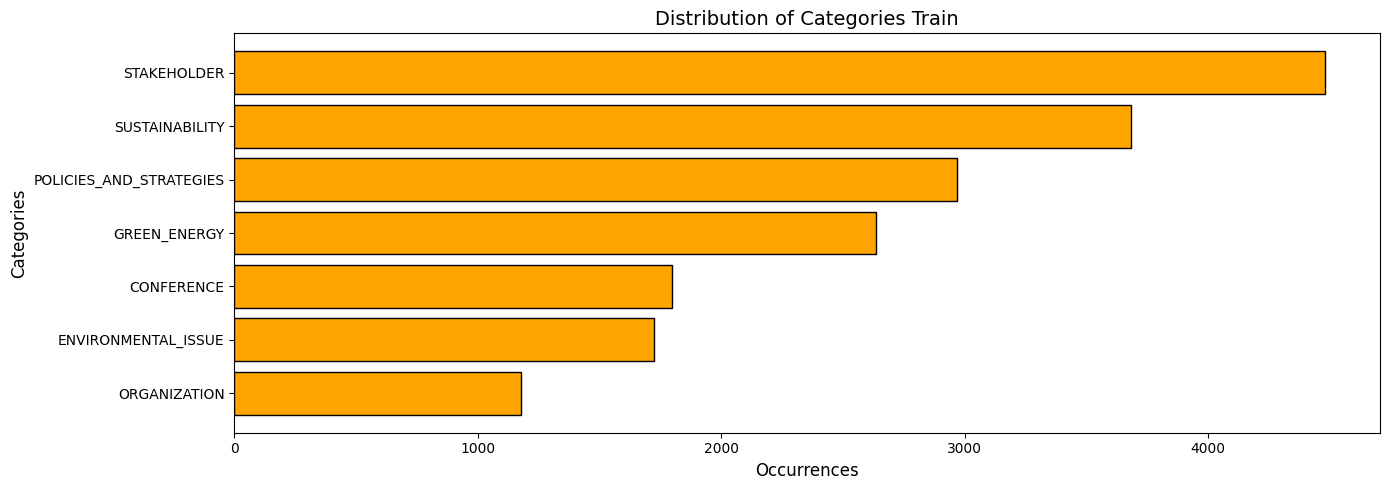

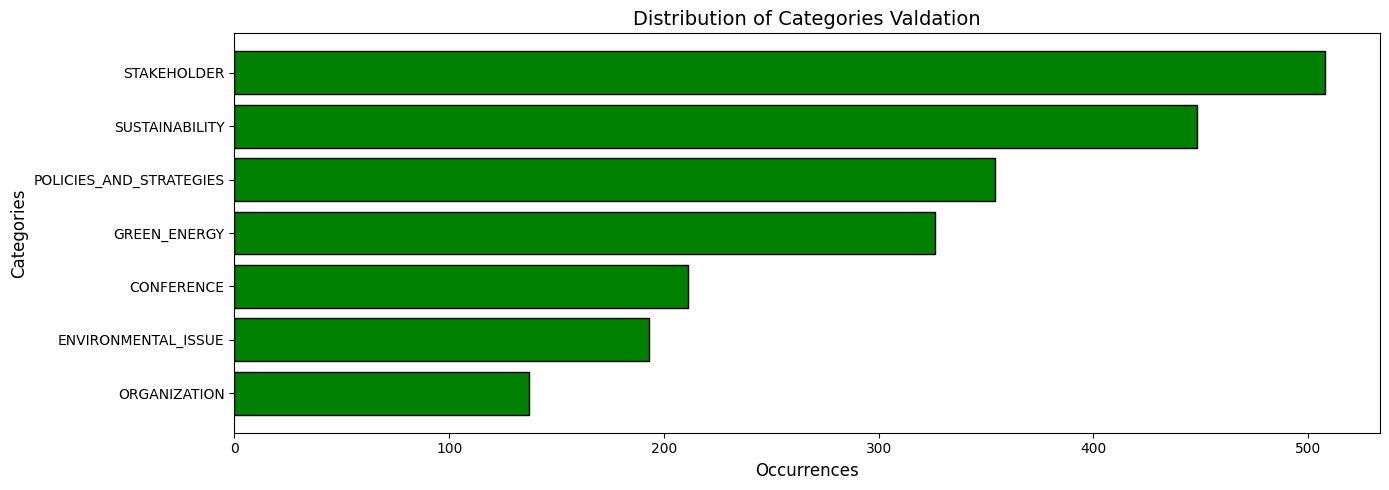

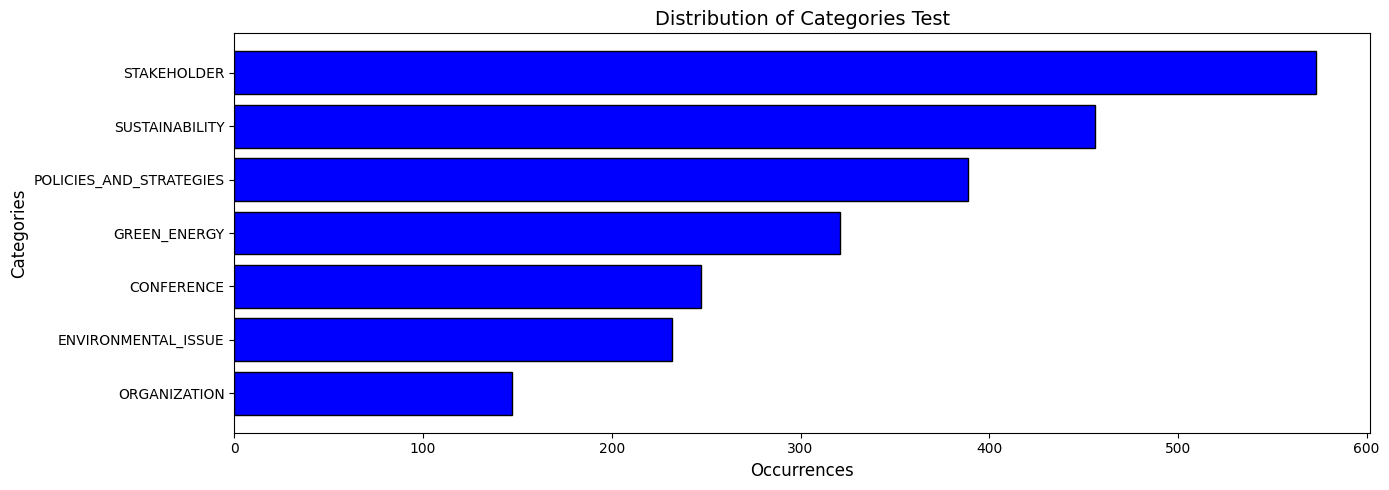

In [118]:
sorted_categories_train = category_counter('cat',TRAIN_FILE)
sorted_categories_val = category_counter('cat',VAL_FILE)
sorted_categories_test = category_counter('cat',TEST_FILE)

plot_stratified_split(sorted_categories_train,'orange','Train')
plot_stratified_split(sorted_categories_val,'green','Valdation')
plot_stratified_split(sorted_categories_test,'blue','Test')

In [78]:
sorted_categories = category_counter('cat',TRAIN_FILE)
sorted_polarities = category_counter('pol',TRAIN_FILE)

## Esempio training set ##
d_cat_count = {k: v for k, v in sorted_categories}
d_pol_count = {k: v for k, v in sorted_polarities}
print("Occorrenze per categoria (ordinate):")
print(d_cat_count)
print("\nOccorrenze per polarità (ordinate):")
print(d_pol_count)

Occorrenze per categoria (ordinate):
{'STAKEHOLDER': 4483, 'SUSTAINABILITY': 3683, 'POLICIES_AND_STRATEGIES': 2971, 'GREEN_ENERGY': 2636, 'CONFERENCE': 1799, 'ENVIRONMENTAL_ISSUE': 1723, 'ORGANIZATION': 1177}

Occorrenze per polarità (ordinate):
{'neutral': 10099, 'positive': 6727, 'negative': 1646}


# Prepare data for the model

In this section we transform the data in a model-readable format

In [25]:
## Positional Encoding of polarity ##
sentiment2id = {'positive': 0, 'neutral':1, 'negative': 2}
id2sentiment = {v:k for k, v in sentiment2id.items()}
id2sentiment

{0: 'positive', 1: 'neutral', 2: 'negative'}

In [26]:
## Positional Encoding of span categories ##
tag2id = {'GREEN_ENERGY': 1,'SUSTAINABILITY' : 2,'ENVIRONMENTAL_ISSUE': 3,'STAKEHOLDER': 4,'ORGANIZATION' : 5,'CONFERENCE':6,'POLICIES_AND_STRATEGIES':7}
id2tag = {v:k for k, v in tag2id.items()}
id2tag

{1: 'GREEN_ENERGY',
 2: 'SUSTAINABILITY',
 3: 'ENVIRONMENTAL_ISSUE',
 4: 'STAKEHOLDER',
 5: 'ORGANIZATION',
 6: 'CONFERENCE',
 7: 'POLICIES_AND_STRATEGIES'}

In [27]:
## IOB tagging strategies (I means Inside and B Beginning, use this to identify the token related to the spans) ##
label2id = {
    **{f'B-{k}': 2*v for v, k in enumerate(tag2id.keys())},
    **{f'I-{k}': 2*v + 1 for v, k in enumerate(tag2id.keys())}
}

id2label = {v: k for k, v in label2id.items()}
id2label = dict(sorted(id2label.items()))
id2label

{0: 'B-GREEN_ENERGY',
 1: 'I-GREEN_ENERGY',
 2: 'B-SUSTAINABILITY',
 3: 'I-SUSTAINABILITY',
 4: 'B-ENVIRONMENTAL_ISSUE',
 5: 'I-ENVIRONMENTAL_ISSUE',
 6: 'B-STAKEHOLDER',
 7: 'I-STAKEHOLDER',
 8: 'B-ORGANIZATION',
 9: 'I-ORGANIZATION',
 10: 'B-CONFERENCE',
 11: 'I-CONFERENCE',
 12: 'B-POLICIES_AND_STRATEGIES',
 13: 'I-POLICIES_AND_STRATEGIES'}

In [ ]:
roberta_tokenizer = AutoTokenizer.from_pretrained("roberta-base")

In [ ]:
data_files = {"train": TRAIN_FILE, "test": TEST_FILE, "val": VAL_FILE}
dataset = load_dataset("json", data_files=data_files)

In [30]:
train_ds = dataset['train']
train_ds

Dataset({
    features: ['text', 'labels'],
    num_rows: 4081
})

In [31]:
test_ds = dataset['test']
test_ds

Dataset({
    features: ['text', 'labels'],
    num_rows: 502
})

In [32]:
val_ds = dataset['val']
val_ds

Dataset({
    features: ['text', 'labels'],
    num_rows: 471
})

In [33]:
MAX_LENGTH = 256

def tokenize_and_adjust_labels(sample, tokenizer=roberta_tokenizer):
    """
    Args:
        - sample (dict): {"text": "...", "labels": [{"start": ..., "end": ..., "span": ...}, ...]}
    Returns:
        - The tokenized version of `sample` and the labels of each token.
    """
    # Tokenize the text, keep the start and end positions of tokens with `return_offsets_mapping` option
    tokenized = tokenizer(sample["text"],
                          return_offsets_mapping=True,
                          padding="max_length",
                          max_length=MAX_LENGTH,
                          truncation=True)

    # Initialize the labels for categories and sentiments (for each token)
    labels_cat = [[0 for _ in label2id.keys()] for _ in range(MAX_LENGTH)]
    labels_pol = [[0 for _ in sentiment2id.keys()] for _ in range(MAX_LENGTH)]

    # Scan all the tokens and spans, assign labels accordingly
    for (token_start, token_end), token_labels_cat, token_labels_pol in zip(tokenized["offset_mapping"], labels_cat, labels_pol):
        # Track the assigned sentiment for the current token
        sentiment = handle_overlapping_spans(token_start, token_end, sample["labels"])

        if sentiment:
            token_labels_pol[sentiment2id[sentiment]] = 1

        # Assign category labels based on the span position
        for span in sample["labels"]:
            if span is None or span.get('category') is None:
                print('Error to identify the span...')
                continue
            try:
                role = get_token_role_in_span(token_start, token_end, span["start"], span["end"])

                if role == "B":
                    token_labels_cat[label2id[f"B-{span['category']}"]] = 1

                elif role == "I":
                    token_labels_cat[label2id[f"I-{span['category']}"]] = 1

            except Exception as e:
                print(e)
                print('Error')
                continue

    return {**tokenized, "labels_cat": labels_cat, "labels_pol": labels_pol}


In [34]:
class ABSADataset(Dataset):
    def __init__(self, dataset,test = False):
        self.dataset = dataset
        self.test = test

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        input_ids = torch.tensor(item["input_ids"])
        text = item["text"]
        attention_mask = torch.tensor(item["attention_mask"])
        labels_cat = torch.tensor(item["labels_cat"])
        labels_pol = torch.tensor(item["labels_pol"])

        if not self.test:
            return {
                "input_ids": input_ids,
                "attention_mask": attention_mask,
                "labels_cat": labels_cat,
                "labels_pol": labels_pol
            }

        else:
            return {
                "text": text,
                "input_ids": input_ids,
                "attention_mask": attention_mask,
                "labels_cat": labels_cat,
                "labels_pol": labels_pol
            }

In [ ]:
tokenized_train_ds = train_ds.map(tokenize_and_adjust_labels)
tokenized_val_ds = val_ds.map(tokenize_and_adjust_labels)

In [36]:
train_dataset = ABSADataset(tokenized_train_ds)
val_dataset = ABSADataset(tokenized_val_ds)

Define the weights for each class, due to the class imbalance

In [37]:
d_cat,n_cat = control_count_output_aggregated(tokenized_train_ds,'labels_cat',id2label,roberta_tokenizer)
dw_cat = compute_weights(n_cat,d_cat)
dw_cat

{'B-GREEN_ENERGY': 3.8267708303803434,
 'I-GREEN_ENERGY': 2.4890295573657237,
 'B-SUSTAINABILITY': 3.5065924390377448,
 'I-SUSTAINABILITY': 2.2126445289359427,
 'B-ENVIRONMENTAL_ISSUE': 4.2655805954642885,
 'I-ENVIRONMENTAL_ISSUE': 2.67961955013743,
 'B-STAKEHOLDER': 3.3173440037953483,
 'I-STAKEHOLDER': 1.745000351440638,
 'B-ORGANIZATION': 4.618917967401507,
 'I-ORGANIZATION': 3.191676438468514,
 'B-CONFERENCE': 4.233457495628679,
 'I-CONFERENCE': 2.472239025386419,
 'B-POLICIES_AND_STRATEGIES': 3.779087670573611,
 'I-POLICIES_AND_STRATEGIES': 1.7385368044246183}

In [38]:
w_cat = assign_weights(id2label,dw_cat)
w_cat

[3.8267708303803434,
 2.4890295573657237,
 3.5065924390377448,
 2.2126445289359427,
 4.2655805954642885,
 2.67961955013743,
 3.3173440037953483,
 1.745000351440638,
 4.618917967401507,
 3.191676438468514,
 4.233457495628679,
 2.472239025386419,
 3.779087670573611,
 1.7385368044246183]

In [39]:
d_pol,n_pol = control_count_output_aggregated(tokenized_train_ds,'labels_pol',id2sentiment,roberta_tokenizer)
dw_pol = compute_weights(n_pol,d_pol)
dw_pol

{'positive': 1.2863031654153023,
 'neutral': 1.0692349950322253,
 'negative': 2.4395308082098586}

In [40]:
w_pol = assign_weights(id2sentiment,dw_pol)
w_pol

[1.2863031654153023, 1.0692349950322253, 2.4395308082098586]

Visualize the token level segmentation, with the associated label

In [41]:
idx_overlap = find_overlapping_spans(tokenized_train_ds)

In [42]:
random.shuffle(idx_overlap)
i = idx_overlap[0]

In [43]:
sample = tokenized_train_ds[i]
control_output(sample,"labels_cat",id2label,roberta_tokenizer)

--------Token---------|--------Labels----------
 <s>                  | []
 EU                   | ['B-STAKEHOLDER']
  climate             | ['I-STAKEHOLDER']
  boss                | ['I-STAKEHOLDER']
  sees                | ['B-POLICIES_AND_STRATEGIES']
  a                   | ['I-POLICIES_AND_STRATEGIES']
  role                | ['I-POLICIES_AND_STRATEGIES']
  for                 | ['I-POLICIES_AND_STRATEGIES']
  natural             | ['B-GREEN_ENERGY', 'I-POLICIES_AND_STRATEGIES']
  gas                 | ['I-GREEN_ENERGY', 'I-POLICIES_AND_STRATEGIES']
  in                  | ['I-POLICIES_AND_STRATEGIES']
  the                 | ['I-POLICIES_AND_STRATEGIES']
  green               | ['I-POLICIES_AND_STRATEGIES']
  energy              | ['I-POLICIES_AND_STRATEGIES']
  transition          | ['I-POLICIES_AND_STRATEGIES']
  -                   | []
                      | []
  As                  | ['B-POLICIES_AND_STRATEGIES']
  long                | ['I-POLICIES_AND_STRATEGIES']
  as   

In [44]:
sample = tokenized_train_ds[i]
control_output(sample,"labels_pol",id2sentiment,roberta_tokenizer)

--------Token---------|--------Labels----------
 <s>                  | ['neutral']
 EU                   | ['neutral']
  climate             | ['neutral']
  boss                | ['neutral']
  sees                | ['neutral']
  a                   | ['neutral']
  role                | ['neutral']
  for                 | ['neutral']
  natural             | ['negative']
  gas                 | ['negative']
  in                  | ['neutral']
  the                 | ['neutral']
  green               | ['neutral']
  energy              | ['neutral']
  transition          | ['neutral']
  -                   | []
                      | []
  As                  | ['neutral']
  long                | ['neutral']
  as                  | ['neutral']
  we                  | ['neutral']
  do                  | ['neutral']
  it                  | ['neutral']
  with                | ['neutral']
  an                  | ['neutral']
  eye                 | ['neutral']
  of                  | ['neutra

# Define the model

The model used is a Roberta pretrained model, we define a multitask model that works with two heads of classification one for the "span categorizer" task and another for "sentiment analysis"

In [45]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, device = "cuda"):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.device = device

    def focal_loss(self, logits, labels, weights, alpha=1, gamma=2):
        bce_loss = F.binary_cross_entropy_with_logits(logits, labels, reduction="none")
        bce_loss = bce_loss.to(self.device)
        pt = torch.exp(-bce_loss)
        pt = pt.to(self.device)
        if weights is not None:
            weights = weights.to(self.device)
            focal_loss = alpha * weights * ((1 - pt) ** gamma) * bce_loss
        else:
            focal_loss = alpha * ((1 - pt) ** gamma) * bce_loss
        return focal_loss.mean()

In [46]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import RobertaPreTrainedModel, RobertaModel

from transformers.utils import (
    add_code_sample_docstrings,
    add_start_docstrings,
    add_start_docstrings_to_model_forward,
    logging,
    replace_return_docstrings,
)
from transformers.models.roberta.modeling_roberta import (
    ROBERTA_INPUTS_DOCSTRING,
    ROBERTA_START_DOCSTRING,
    RobertaEmbeddings,
    #_TOKENIZER_FOR_DOC
)

from typing import Optional, Union, Tuple
from transformers.modeling_outputs import TokenClassifierOutput


class RobertaForABSA(RobertaPreTrainedModel):
    _keys_to_ignore_on_load_unexpected = [r"pooler"]
    _keys_to_ignore_on_load_missing = [r"position_ids"]

    def __init__(self, config):
        super().__init__(config)
        self.num_labels_cat = config.num_labels_cat
        self.num_labels_pol = config.num_labels_pol
        self.w_cat = torch.tensor(config.w_cat, dtype=torch.float32)
        self.w_pol = torch.tensor(config.w_pol, dtype=torch.float32)


        self.roberta = RobertaModel(config, add_pooling_layer=False)

        self.w_cat = self.w_cat.to(self.device)
        self.w_pol = self.w_pol.to(self.device)
        self.FL = FocalLoss()

        classifier_dropout = (
            config.classifier_dropout if config.classifier_dropout is not None else config.hidden_dropout_prob
        )
        self.dropout = nn.Dropout(classifier_dropout)

        ## First head for Span Categorization Task
        self.classifier1 = nn.Linear(config.hidden_size, self.num_labels_cat)
        ## Second head for Sentiment Analysis Task
        self.classifier2 = nn.Linear(config.hidden_size, self.num_labels_pol)

        self.post_init()


    @add_start_docstrings_to_model_forward(ROBERTA_INPUTS_DOCSTRING.format("batch_size, sequence_length"))
    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.FloatTensor] = None,
        token_type_ids: Optional[torch.LongTensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        labels_cat: Optional[torch.FloatTensor] = None,
        labels_pol: Optional[torch.FloatTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple[torch.Tensor], dict]:
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.roberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = outputs[0]
        sequence_output = self.dropout(sequence_output)

        ## First Head logits
        logits_cat = self.classifier1(sequence_output)
        ## Second Head logits
        logits_pol = self.classifier2(sequence_output)


        ## Loss
        loss_cat = None
        loss_pol = None
        if labels_cat is not None:
            loss_cat = self.FL.focal_loss(logits_cat, labels_cat.float(), weights=self.w_cat)
        if labels_pol is not None:
            loss_pol = self.FL.focal_loss(logits_pol, labels_pol.float(), weights=self.w_pol)

        alpha = 0.98
        loss = None
        if loss_cat is not None and loss_pol is not None:
            loss = (alpha * loss_cat) + (( 1 - alpha) * loss_pol)
        elif loss_cat is not None:
            loss = loss_cat
        elif loss_pol is not None:
            loss = loss_pol

        # Output
        if not return_dict:
            output = (logits_cat, logits_pol) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return TokenClassifierOutput(
            loss=loss,
            logits=(logits_cat, logits_pol),
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )


# Define the metrics

In [170]:
def divide(a: int, b: int):
    return a / b if b > 0 else 0

In [171]:
## Aggregate the B-I tag in one label, for each category in CATEGORIES ##
def bitwise_or_pairs(arr):
    """
    Applies bitwise OR operation to consecutive pairs in an array.

    Args:
        - arr (array): The input array.

    Returns:
        - result (array): The array after applying bitwise OR operation.
    """
    arr_tmp = arr.tolist()
    # Explicitly cast the data type to integers before applying bitwise OR
    result = []

    for element in arr_tmp:
        for i in range(0,len(element),2):
            result.append(int(element[i]) | int(element[i+1]))

    result = np.array(result).reshape(-1,len(CATEGORIES))
    return result

In [172]:
def compute_metrics(y_pred, y_true, n_labels, id2label, task ,threshold = 0.5):
    y_probs = torch.sigmoid(torch.from_numpy(y_pred))
    y_pred = np.where(y_probs.numpy() > threshold, np.ones(y_pred.shape), np.zeros(y_pred.shape))

    y_true = y_true.reshape(-1, n_labels)
    y_pred = y_pred.reshape(-1, n_labels)

    metrics = {}

    cm = multilabel_confusion_matrix(y_true, y_pred)

    for label_idx, matrix in enumerate(cm):

        tp, fp, fn = matrix[1, 1], matrix[0, 1], matrix[1, 0]
        precision = divide(tp, tp + fp)
        recall = divide(tp, tp + fn)
        f1 = divide(2 * precision * recall, precision + recall)


        metrics[f"f1_{id2label[label_idx]}"] = f1
        metrics[f"precision_{id2label[label_idx]}"] = precision
        metrics[f"recall_{id2label[label_idx]}"] = recall


    macro_f1 = np.mean([metrics[f"f1_{id2label[i]}"] for i in range(n_labels)])
    macro_precision = np.mean([metrics[f"precision_{id2label[i]}"] for i in range(n_labels)])
    macro_recall = np.mean([metrics[f"recall_{id2label[i]}"] for i in range(n_labels)])


    if task == "task1":
        y_true_aggregated = bitwise_or_pairs(y_true)
        y_pred_aggregated = bitwise_or_pairs(y_pred)


        cm_aggregated = multilabel_confusion_matrix(y_true_aggregated, y_pred_aggregated)

        for label_idx, matrix in enumerate(cm_aggregated):
            tp, fp, fn = matrix[1, 1], matrix[0, 1], matrix[1, 0]
            precision = divide(tp, tp + fp)
            recall = divide(tp, tp + fn)
            f1 = divide(2 * precision * recall, precision + recall)

            metrics[f"f1_{id2tag[label_idx + 1]}_comb"] = f1
            metrics[f"precision_{id2tag[label_idx + 1]}_comb"] = precision
            metrics[f"recall_{id2tag[label_idx + 1]}_comb"] = recall

        macro_f1_aggregated = np.mean([metrics[f"f1_{id2tag[i]}_comb"] for i in range(1,len(CATEGORIES)+1)])
        macro_precision_aggregated = np.mean([metrics[f"precision_{id2tag[i]}_comb"] for i in range(1,len(CATEGORIES)+1)])
        macro_recall_aggregated = np.mean([metrics[f"recall_{id2tag[i]}_comb"] for i in range(1,len(CATEGORIES)+1)])


    metrics[f"macro_f1_{task}"] = macro_f1
    metrics[f"macro_precision_{task}"] = macro_precision
    metrics[f"macro_recall_{task}"] = macro_recall

    if task == "task1":
        metrics[f"macro_f1_aggregated_{task}"] = macro_f1_aggregated
        metrics[f"macro_precision_aggregated_{task}"] = macro_precision_aggregated
        metrics[f"macro_recall_aggregated_{task}"] = macro_recall_aggregated

    return metrics

In [173]:
def compute_multitask_metrics(eval_pred):

    predictions, labels = eval_pred
    logits_cat, logits_pol = predictions
    true_labels_cat, true_labels_pol = labels


    num_classes_task1 = len(id2label)
    num_classes_task2 = len(id2sentiment)

    # Calcolo delle metriche per entrambi i task
    metrics_task1 = compute_metrics(logits_cat, true_labels_cat, num_classes_task1, id2label,"task1")
    metrics_task2 = compute_metrics(logits_pol, true_labels_pol, num_classes_task2, id2sentiment,"task2")


    overall_macro_f1 = (metrics_task1["macro_f1_aggregated_task1"] + metrics_task2["macro_f1_task2"]) / 2
    overall_macro_precision = (metrics_task1["macro_precision_aggregated_task1"] + metrics_task2["macro_precision_task2"]) / 2
    overall_macro_recall = (metrics_task1["macro_recall_aggregated_task1"] + metrics_task2["macro_recall_task2"]) / 2


    combined_metrics = {
        **metrics_task1,
        **metrics_task2,
        "overall_macro_f1" : overall_macro_f1,
        "overall_macro_precision": overall_macro_precision,
        "overall_macro_recall": overall_macro_recall
    }
    return combined_metrics


# Fine Tuning

In [51]:
from transformers import DataCollatorForTokenClassification, RobertaConfig, TrainingArguments, Trainer

In [52]:
data_collator = DataCollatorForTokenClassification(tokenizer=roberta_tokenizer)

In [ ]:
## Model Configuration ##
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = RobertaConfig.from_pretrained("roberta-base")
config.num_labels_cat = len(id2label)  ## ---> First head number of labels
config.num_labels_pol = len(id2sentiment)  ## ---> Second head number of labels
config.w_cat = w_cat
config.w_pol = w_pol


model = RobertaForABSA.from_pretrained("roberta-base", config=config)

In [174]:
training_args = TrainingArguments(
    output_dir= MODEL_PATH,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit= 2,
    learning_rate=3.5e-5,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    num_train_epochs= 10,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="overall_macro_f1",
    seed = 12345,
    resume_from_checkpoint = True
)

In [175]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset = train_dataset,
    eval_dataset = val_dataset,
    tokenizer = roberta_tokenizer,
    data_collator = data_collator,
    compute_metrics = compute_multitask_metrics,
)


In [ ]:
CHECKPOINT = False

In [ ]:
if CHECKPOINT:
    trainer.train(resume_from_checkpoint = True)

else:
    trainer.train()

In [ ]:
trainer.model.save_pretrained(MODEL_PATH)

# Test and Inference

In [53]:
model = RobertaForABSA.from_pretrained(MODEL_PATH)
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

In [ ]:
tokenized_test_ds = test_ds.map(tokenize_and_adjust_labels)

In [57]:
tokenized_test_ds

Dataset({
    features: ['text', 'labels', 'input_ids', 'attention_mask', 'offset_mapping', 'labels_cat', 'labels_pol'],
    num_rows: 502
})

In [58]:
test_dataset = ABSADataset(tokenized_test_ds,test = True)

In [176]:
test_results = trainer.predict(test_dataset)

In [177]:
metrics = test_results[2]

In [178]:
metrics = partition_results(metrics)

In [179]:
res_file = os.path.join(RESULTS_MODEL_PATH, "results_metrics.json")

In [ ]:
save_metrics_to_file(metrics,res_file)

In [181]:
loaded_metrics = load_metrics_from_file(res_file)

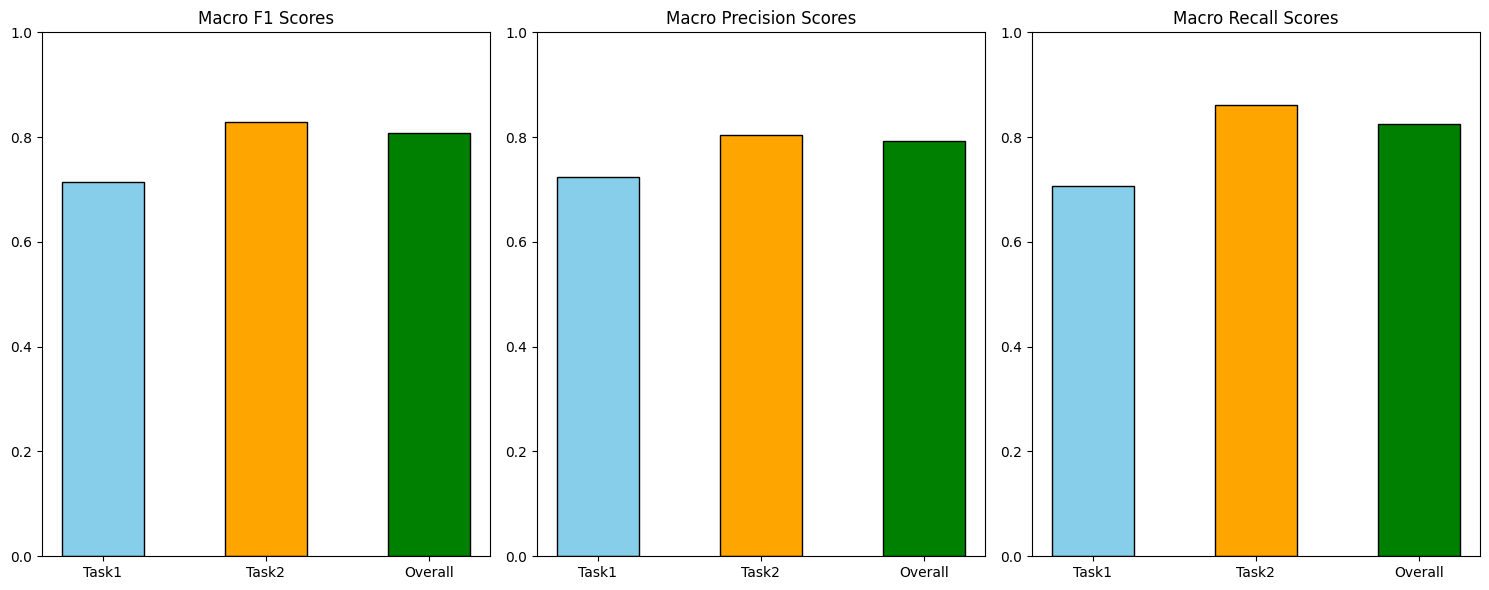

In [165]:
PLOT_FILE = os.path.join(RESULTS_MODEL_PATH, "results_plot_metrics.png")
plot_metrics(loaded_metrics, PLOT_FILE)

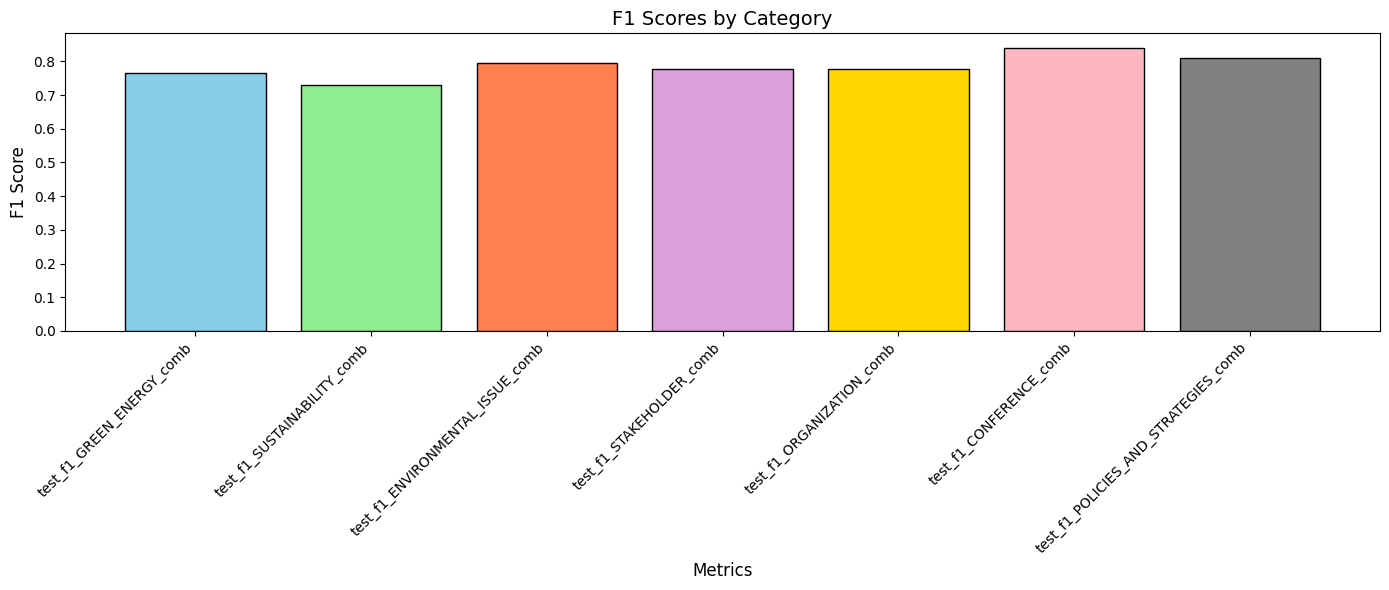

In [185]:
## Plot F1 scores for each label/category ##
PLOT_FILE = os.path.join(RESULTS_MODEL_PATH, "results_plot_categories_aggregated.png")
plot_f1_categories(loaded_metrics,True, PLOT_FILE)

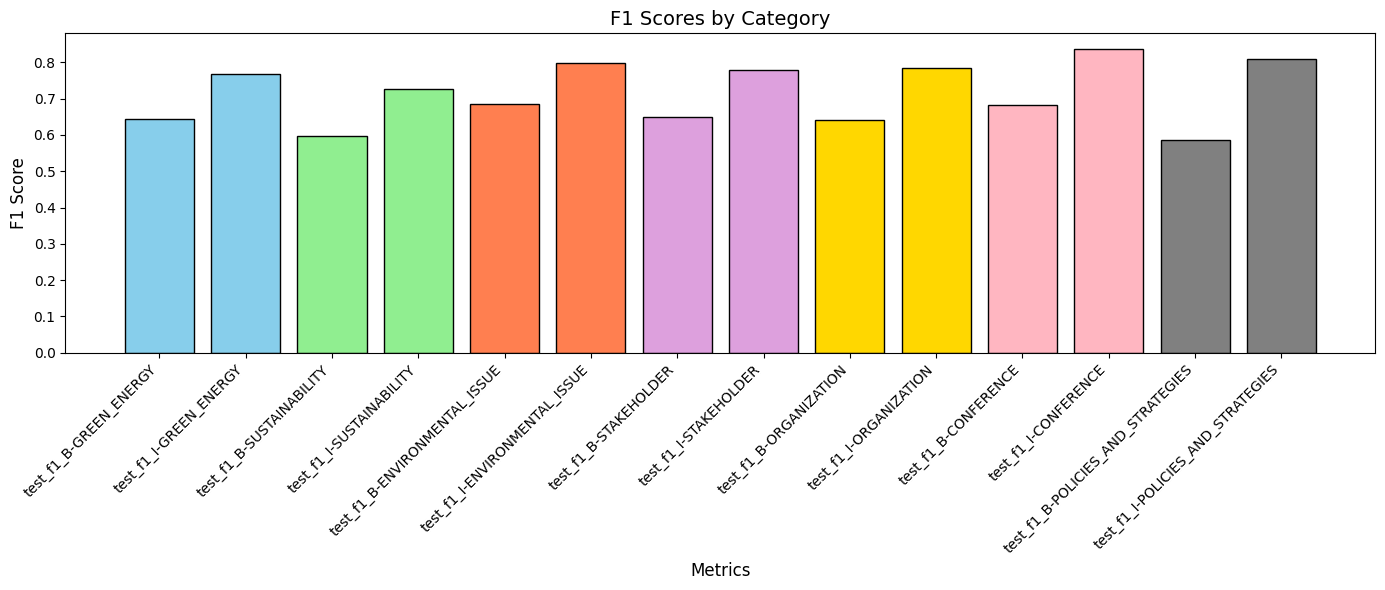

In [188]:
## Plot F1 scores for tag B and I for each category ##
PLOT_FILE = os.path.join(RESULTS_MODEL_PATH,"results_plot_categories")
plot_f1_categories(loaded_metrics,False, PLOT_FILE)

In [ ]:
## Convert the output of the model in a human-readable format ##

def get_tagged_groups(example, model, tokenizer):
    """
    Get prediction of model on example, using tokenizer
    Returns:
    - List of spans under offset format {"start": ..., "end": ..., "tag": ..., "polarity":...}, sorted by start.
    """
    offsets_and_tags = get_offsets_and_predicted_tags(example, model, tokenizer)
    predicted_offsets = {l: [] for l in tag2id}
    last_token_tags = []
    last_token_pols = []

    for item in offsets_and_tags:
        (start, end), cats, pols = item["offset"], item["categories"], item["polarities"]

        for label_id in cats:
            label = id2label[label_id]
            tag = label[2:]  # "I-PER" => "PER"

            if label.startswith("B-"):
                # Start a new group
                predicted_offsets[tag].append({"start": start, "end": end, "polarity": set()})
            elif label.startswith("I-"):
                # Continue an existing group if valid
                if label2id[f"B-{tag}"] in cats:
                    continue

                if label_id not in last_token_tags and label2id[f"B-{tag}"] not in last_token_tags:
                    predicted_offsets[tag].append({"start": start, "end": end, "polarity": set()})
                else:
                    predicted_offsets[tag][-1]["end"] = end

            # Add polarities
            if predicted_offsets[tag]:
                predicted_offsets[tag][-1]["polarity"].update(pols)

        last_token_tags = cats
        last_token_pols = pols

    # Flatten and format the output
    flatten_predicted_offsets = [
        {
            **v,
            "category": k,
            "span": example[v["start"]:v["end"]],
            "polarity": id2sentiment[list(v["polarity"])[0]] if v["polarity"] else "negative"
        }
        for k, v_list in predicted_offsets.items() for v in v_list if v["end"] - v["start"] >= 3
    ]
    flatten_predicted_offsets = sorted(
        flatten_predicted_offsets,
        key=lambda row: (row["start"], row["end"], row["category"],row["polarity"])
    )
    return flatten_predicted_offsets

In [ ]:
example = "During COP27, world leaders emphasized the urgent need for increased climate financing to support vulnerable nations in adapting to the impacts of global warming."

In [ ]:
get_tagged_groups(example, model, tokenizer)

[{'start': 7,
  'end': 12,
  'polarity': 'neutral',
  'category': 'CONFERENCE',
  'span': 'COP27'},
 {'start': 14,
  'end': 27,
  'polarity': 'neutral',
  'category': 'STAKEHOLDER',
  'span': 'world leaders'},
 {'start': 43,
  'end': 86,
  'polarity': 'positive',
  'category': 'POLICIES_AND_STRATEGIES',
  'span': 'urgent need for increased climate financing'},
 {'start': 136,
  'end': 161,
  'polarity': 'negative',
  'category': 'ENVIRONMENTAL_ISSUE',
  'span': 'impacts of global warming'}]